#### Imports

In [1]:
# Manipulation & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Configure Visualizations
%matplotlib inline

# SettingWithCopyWarning
pd.options.mode.chained_assignment = None

#### Grab Data

In [2]:
# Bonds
fgbs_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\FGBS_Day1.csv')
fgbm_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\FGBM_Day1.csv')
fgbl_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\FGBL_Day1.csv')
fgbx_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\FGBX_Day1.csv')
zt_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\ZT_Day1.csv')
zf_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\ZF_Day1.csv')
zn_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\ZN_Day1.csv')
tn_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\TN_Day1.csv')
zb_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\ZB_Day1.csv')
ub_df = pd.read_csv(r'C:\Users\Brian\Desktop\PriceData\Day1\Bonds\UB_Day1.csv')

#### Wrangling

In [3]:
# Copy for wrangling
fgbs = fgbs_df.copy()
fgbm = fgbm_df.copy()
fgbl = fgbl_df.copy()
fgbx = fgbx_df.copy()
zt = zt_df.copy()
zf = zf_df.copy()
zn = zn_df.copy()
tn = tn_df.copy()
zb = zb_df.copy()
ub = ub_df.copy()

In [4]:
# Put dataframes in a list for ease.
bonds = [
    fgbs,
    fgbm,
    fgbl,
    fgbx,
    zt,
    zf,
    zn,
    tn,
    zb,
    ub]

In [5]:
def check_nan(df: pd.DataFrame):
    """ Check for NaN values. """
    if df.isnull().values.any():
        print('There is missing data.')
        
for df in bonds:
    check_nan(df)

In [6]:
def time_object_to_timeseries(df: pd.DataFrame) -> pd.DataFrame:
    """ Remove M/S/MS from 'Time' and convert into datetime. """
    df['Time'] = [x[:-11] for x in df['Time']]
    df['Time'] = pd.to_datetime(df['Time'])
    
    return df

for df in bonds:
    time_object_to_timeseries(df)

In [7]:
def add_weekday(df: pd.DataFrame) -> pd.DataFrame:
    """ Create a column specifying what day of the week it is. """
    df['Weekday'] = [str(x.weekday()) for x in df['Time']]
    
    return df

for df in bonds:
    add_weekday(df)

In [8]:
def change_ohlc_type(df: pd.DataFrame) -> pd.DataFrame:
    """ Turn O/H/L/C from string to float. """
    df[['Open', 'High', 'Low', 'Close']] = df[['Open', 'High', 'Low', 'Close']].astype(float)

    return df

for df in bonds:
    change_ohlc_type(df)

In [9]:
def create_range(df: pd.DataFrame) -> pd.DataFrame:
    """ Create a column holdingthe range for the session. """
    df['Range'] = [x['High'] - x['Low'] for x in df.iloc]

    return df

for df in bonds:
    create_range(df)

In [10]:
def up_or_down_session(df: pd.DataFrame) -> pd.DataFrame:
    """ Create a column denoting if sessions was Flat/Up/Down. """
    df['Up/Down Session'] = df['Close'] - df['Open']
    df['Up/Down Session'] = [0 if x == 0 else 1 if x > 0 else -1 for x in df['Up/Down Session'].iloc]

    return df

for df in bonds:
    up_or_down_session(df)

In [11]:
def up_or_down_from_prior_session(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a column denoting if the current session is Flat/Up/Down,
    in comparison to prior session.
    """
    df['Up/Down Prior Session'] = df['Up/Down Session'].shift()
    
    return df

for df in bonds:
    up_or_down_from_prior_session(df)

#### Modelling

In [12]:
# Copy for modelling
fgbs_modelling = fgbs.copy()
fgbm_modelling = fgbm.copy()
fgbl_modelling = fgbl.copy()
fgbx_modelling = fgbx.copy()
zt_modelling = zt.copy()
zf_modelling = zf.copy()
zn_modelling = zn.copy()
tn_modelling = tn.copy()
zb_modelling = zb.copy()
ub_modelling = ub.copy()

In [13]:
def morph_df_for_modelling(df: pd.DataFrame) -> pd.DataFrame:
    """ Create dataframe to use for modelling. """
    df = df[['Weekday', 'Up/Down Session', 'Up/Down Prior Session']]
    df.dropna(inplace=True)
    
    return df

fgbs_modelling = morph_df_for_modelling(fgbs_modelling)
fgbm_modelling = morph_df_for_modelling(fgbm_modelling)
fgbl_modelling = morph_df_for_modelling(fgbl_modelling)
fgbx_modelling = morph_df_for_modelling(fgbx_modelling)
zt_modelling = morph_df_for_modelling(zt_modelling)
zf_modelling = morph_df_for_modelling(zf_modelling)
zn_modelling = morph_df_for_modelling(zn_modelling)
tn_modelling = morph_df_for_modelling(tn_modelling)
zb_modelling = morph_df_for_modelling(zb_modelling)
ub_modelling = morph_df_for_modelling(ub_modelling)

In [14]:
def model_bonds(df: pd.DataFrame) -> dict:
    """ Prepare dataframe for training/testing into models. """
    np.random.seed(42)
    X = df.drop(['Up/Down Session'], axis=1)
    y = df['Up/Down Session']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    models = {'Logistic Regression': LogisticRegression(),
              'KNN': KNeighborsClassifier(),
              'Random Forest': RandomForestClassifier()}
    
    def fit_and_score(models: dict, X_train, X_test, y_train, y_test) -> dict:
        """
        Fits and evaluates given ml models.
        models: a dictionary of Scikit-Learn ml models
        X_train: training data (no labels)
        X_test: testing data (no labels)
        y_train: training labels
        y_test: test labels
        """
        np.random.seed(42)
        model_scores = {}
        for name, model in models.items():
            model.fit(X_train, y_train)
            model_scores[name] = model.score(X_test, y_test)

        return model_scores
    
    return fit_and_score(models=models,
                         X_train=X_train,
                         X_test = X_test,
                         y_train = y_train,
                         y_test = y_test)

fgbs_models = model_bonds(fgbs_modelling)
fgbm_models = model_bonds(fgbm_modelling)
fgbl_models = model_bonds(fgbl_modelling)
fgbx_models = model_bonds(fgbx_modelling)
zt_models = model_bonds(zt_modelling)
zf_models = model_bonds(zf_modelling)
zn_models = model_bonds(zn_modelling)
tn_models = model_bonds(tn_modelling)
zb_models = model_bonds(zb_modelling)
ub_models = model_bonds(ub_modelling)

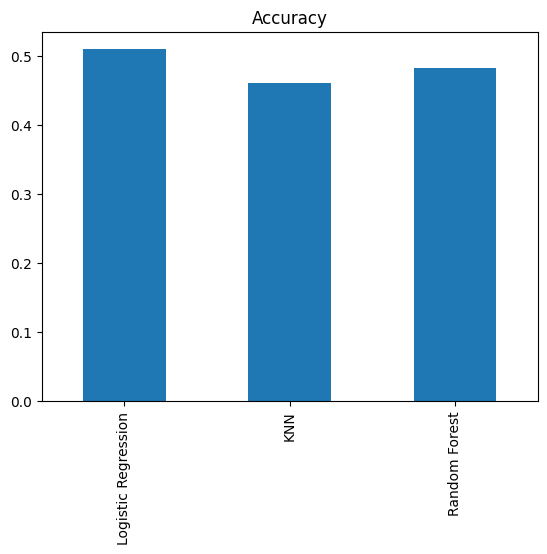

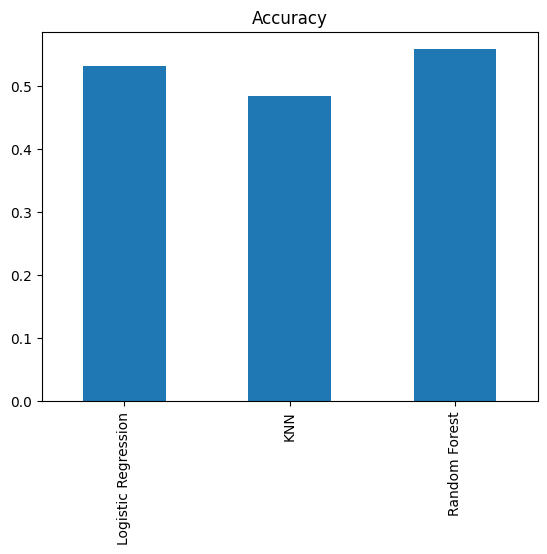

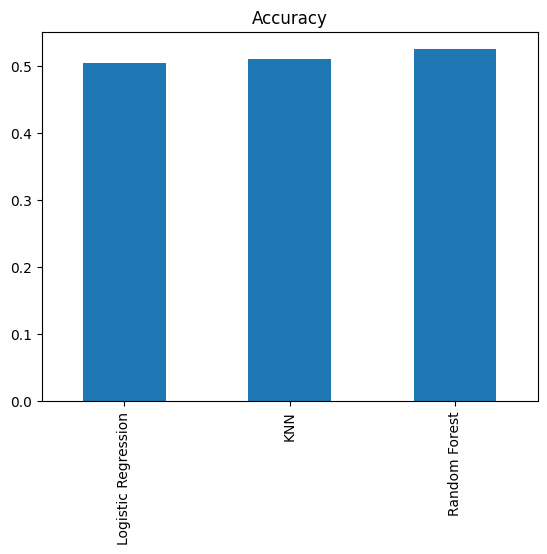

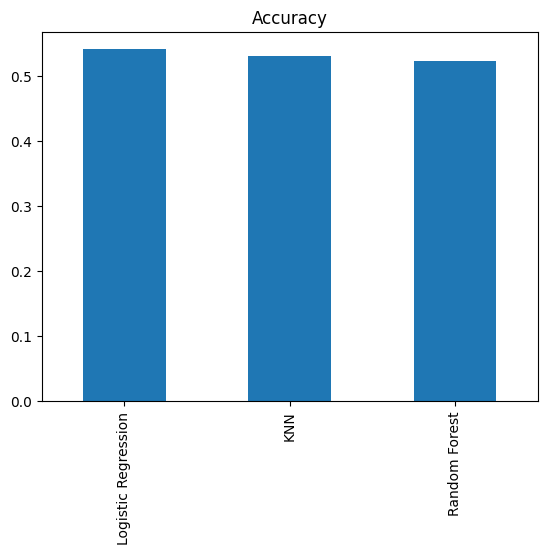

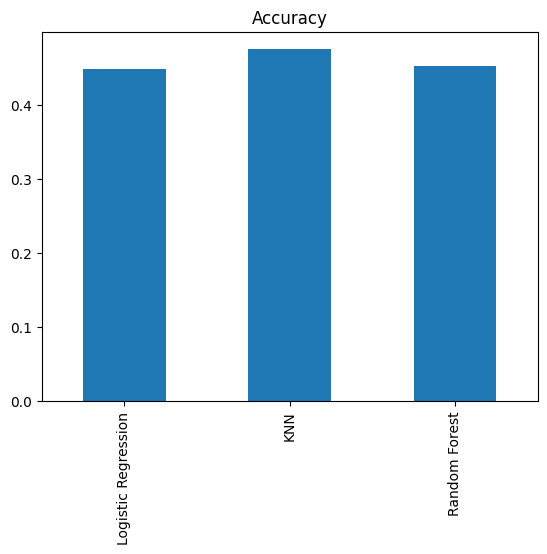

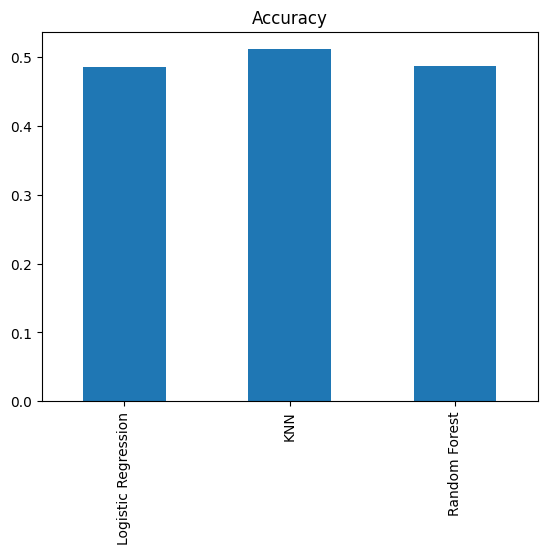

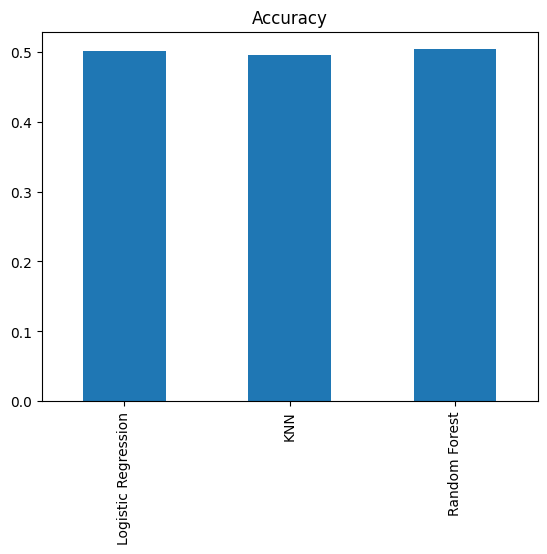

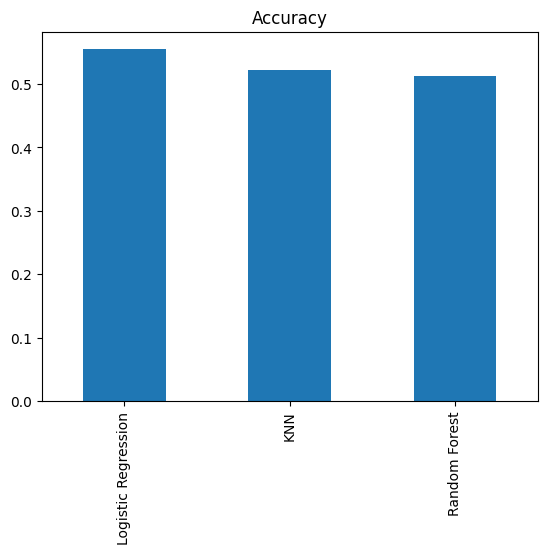

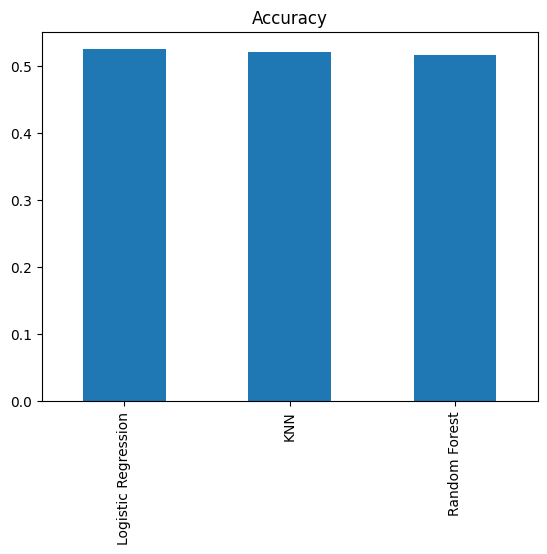

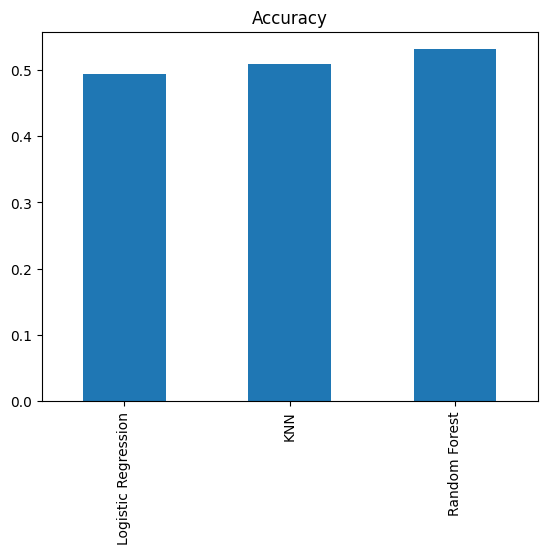

In [16]:
def plot_models_results(df: pd.DataFrame)-> plt.axes:
    model_compare = pd.DataFrame(df, index=['Accuracy'])
    return model_compare.T.plot.bar(legend=False, title='Accuracy')

fgbs_models_plot = plot_models_results(fgbs_models)
fgbm_models_plot = plot_models_results(fgbm_models)
fgbl_models_plot = plot_models_results(fgbl_models)
fgbx_models_plot = plot_models_results(fgbx_models)
zt_models_plot = plot_models_results(zt_models)
zf_models_plot = plot_models_results(zf_models)
zn_models_plot = plot_models_results(zn_models)
tn_models_plot = plot_models_results(tn_models)
zb_models_plot = plot_models_results(zb_models)
ub_models_plot = plot_models_results(ub_models)

#### Further Modelling - KNN

In [18]:
def knn_modelling_and_visualization(df: pd.DataFrame) -> dict:
    """ Prepare dataframe for training/testing into knn modelling and show visualization. """
    np.random.seed(42)
    X = df.drop(['Up/Down Session'], axis=1)
    y = df['Up/Down Session']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    train_scores = []
    test_scores = []
    neighbors = range(1, 21)

    knn = KNeighborsClassifier()

    for i in neighbors:
        knn.set_params(n_neighbors=i)
        knn.fit(X_train, y_train)
        train_scores.append(knn.score(X_train, y_train))
        test_scores.append(knn.score(X_test, y_test))
        
    plt.plot(neighbors, train_scores, label='Train Score')
    plt.plot(neighbors, test_scores, label='Test Score')
    plt.xticks(np.arange(1, 21, 1))
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Model Score')
    plt.legend()

    print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

Maximum KNN score on the test data: 47.33%


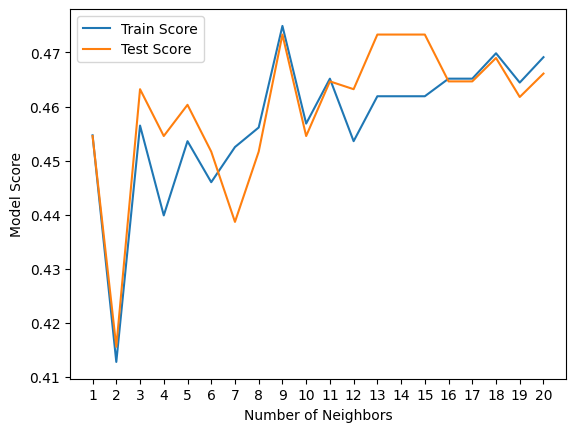

In [19]:
fgbs_knn_model = knn_modelling_and_visualization(fgbs_modelling)

Maximum KNN score on the test data: 49.21%


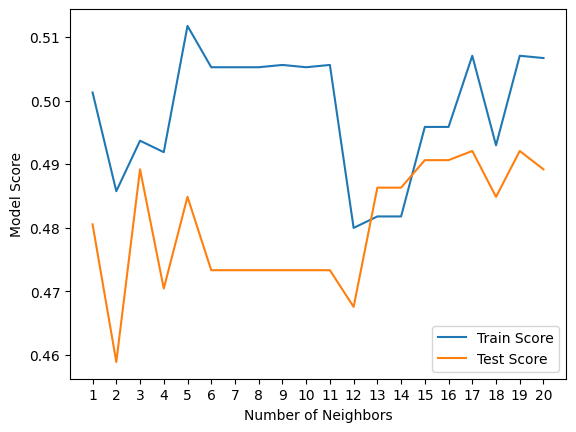

In [20]:
fgbm_knn_model = knn_modelling_and_visualization(fgbm_modelling)

Maximum KNN score on the test data: 52.74%


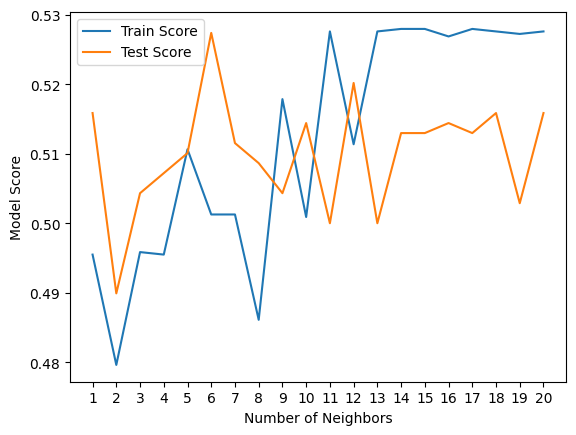

In [21]:
fgbl_knn_model = knn_modelling_and_visualization(fgbl_modelling)

Maximum KNN score on the test data: 54.59%


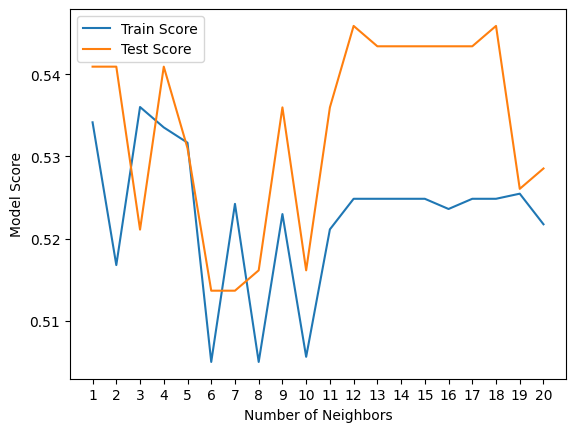

In [22]:
fgbx_knn_model = knn_modelling_and_visualization(fgbx_modelling)

Maximum KNN score on the test data: 49.44%


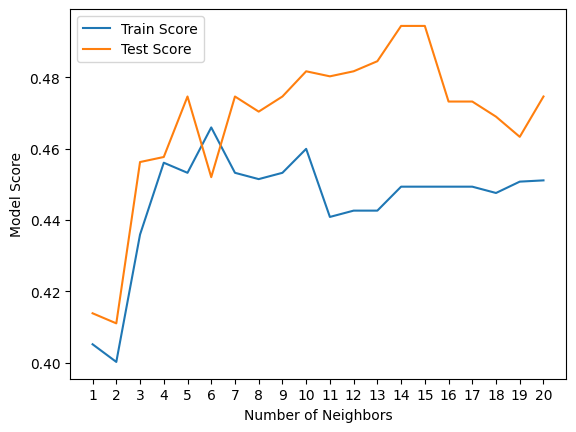

In [23]:
zt_knn_model = knn_modelling_and_visualization(zt_modelling)

Maximum KNN score on the test data: 51.55%


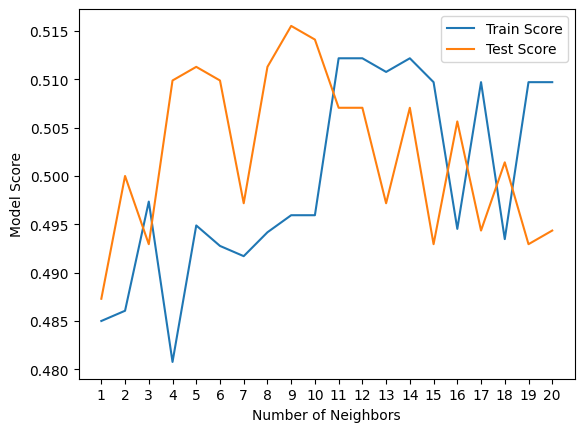

In [24]:
zf_knn_model = knn_modelling_and_visualization(zf_modelling)

Maximum KNN score on the test data: 51.90%


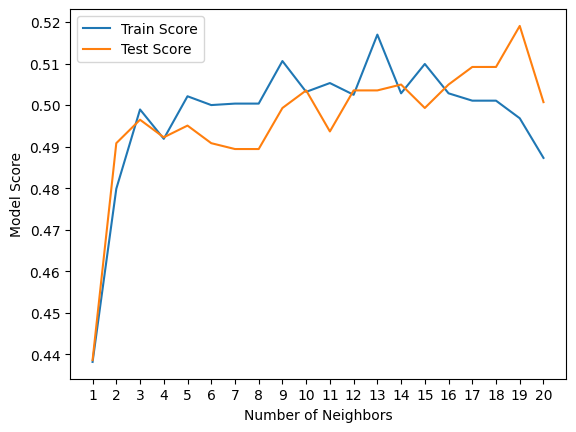

In [25]:
zn_knn_model = knn_modelling_and_visualization(zn_modelling)

Maximum KNN score on the test data: 52.42%


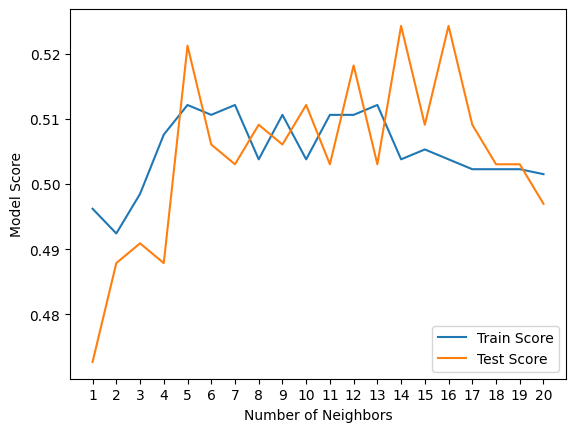

In [26]:
tn_knn_model = knn_modelling_and_visualization(tn_modelling)

Maximum KNN score on the test data: 55.15%


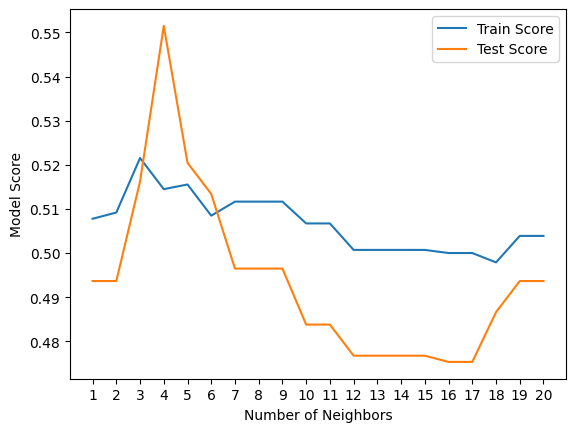

In [27]:
zb_knn_model = knn_modelling_and_visualization(zb_modelling)

Maximum KNN score on the test data: 51.48%


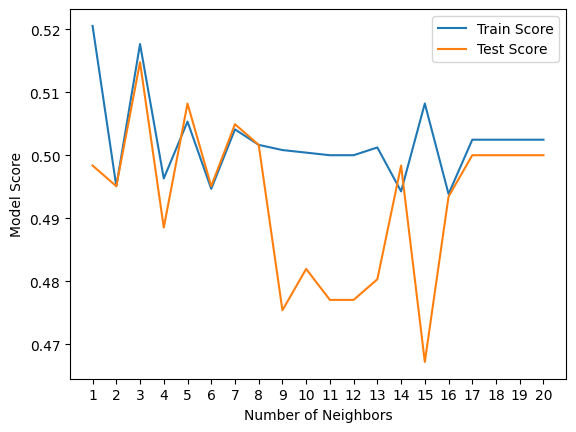

In [28]:
ub_knn_model = knn_modelling_and_visualization(ub_modelling)